In [8]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from scipy import fftpack,signal
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.special import jv
import scipy.signal as sg
import cmath
from scipy import interpolate
import math
import pandas as pd
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform

In [47]:
# 降到低维CS对称的动量点 —— 以Chern insulator 为例
#只加hz方面的非厄米

def RammaLattice2D(mz,t0,tso,kx,ky,gamma): # 定义Chern 绝缘体 
    sigmax = np.array([[0,1],[1,0]])
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    H = (mz-2*t0*np.cos(kx)-2*t0*np.cos(ky))*sigmaz + (2*tso*np.sin(kx))*sigmax + (2*tso*np.sin(ky))*sigmay + 1j*gamma*sigmaz
    return H


def SpinNonEmitianAveTime(mz, t0, tso, kx, ky, gamma, rho0, Time):
    dt = Time[1] - Time[0]
    H = RammaLattice2D(mz, t0, tso, kx, ky, gamma)
    HL = H.T.conjugate()
    
    sigmay = np.array([[0, -1j], [1j, 0]])
    sigmax = np.array([[0, 1], [1, 0]])
    sigmaz = np.array([[1, 0], [0, -1]])

    dU = expm(-1j * H * dt)
    dUL = expm(1j * HL * dt)

    rho = np.zeros((len(Time), 2, 2), dtype=complex)
    rho[0] = rho0 / np.trace(rho0)  # 初始归一化

    Spinx = np.zeros(len(Time), dtype=complex)
    Spiny = np.zeros(len(Time), dtype=complex)
    Spinz = np.zeros(len(Time), dtype=complex)

    for ti in range(len(Time) - 1):
        # ρ(t+dt) = dU ρ(t) dUL
        rho_temp = dU@rho[ti]@dUL
        rho[ti+1] = rho_temp / np.trace(rho_temp)  # 步进归一化

    for i in range(len(Time)):
        Spinx[i] = np.trace(rho[i] @ sigmax)
        Spiny[i] = np.trace(rho[i] @ sigmay)
        Spinz[i] = np.trace(rho[i] @ sigmaz)

    SpinxAve = np.sum(Spinx * dt) / Time[-1]
    SpinyAve = np.sum(Spiny * dt) / Time[-1]
    SpinzAve = np.sum(Spinz * dt) / Time[-1]

    return SpinxAve, SpinyAve, SpinzAve

In [5]:
mz = 3
t0 = 1
tso = 0.5
gamma = 0.4
kx =  np.linspace(-np.pi,np.pi,100)
ky= np.linspace(-np.pi,np.pi,100)
sigmaz = np.array([[1,0],[0,-1]])
sigmax = np.array([[0,1],[1,0]])
sigmay = np.array([[0,-1j],[1j,0]])
Time=np.arange(0,1000,0.2)
SpinxLTST = np.zeros((len(kx),len(ky)),dtype=complex)
SpinyLTST =  np.zeros((len(kx),len(ky)),dtype=complex)
SpinzLTST =  np.zeros((len(kx),len(ky)),dtype=complex)
rho0 = 1/2*(np.eye(2)+(sigmaz))
for i in np.arange(len(kx)):
    for j in np.arange(len(ky)):
        SpinxLTST[i][j],SpinyLTST[i][j],SpinzLTST[i][j] = SpinNonEmitianAveTime(mz,t0,tso,kx[i],ky[j],gamma,rho0,Time)

In [ ]:
kxBIS, kyBIS = sym.symbols('kxBIS kyBIS',real=True)
kxBIS = np.linspace(-np.pi,np.pi,100)
kyB = []
kxB = []

for i in np.arange(len(kxBIS)):
    kyi = sym.solve(mz - 2*t0*sym.cos(kxBIS[i]) - 2*t0*sym.cos(kyBIS),kyBIS)
    kyi_floats = np.array([sol.evalf(n=50) for sol in kyi]).astype(float)
    kyi_floats = np.mod(kyi_floats + np.pi, 2 * np.pi) - np.pi
    kxB.append(np.ones(len(kyi_floats))*kxBIS[i])
    kyB.append(kyi_floats)
kxB1 = np.concatenate(kxB)
kyB1 = np.concatenate(kyB)
r = np.sqrt(kxB1**2+kyB1**2)
theta1 =(np.arctan2(kxB1,kyB1))
indextheta = np.argsort(theta1)
rsort = r[indextheta]
theta1sort = theta1[indextheta]
linear_interp = interpolate.interp1d(theta1sort,rsort, kind='linear',fill_value='extrapolate')
phi = np.linspace(-np.pi,np.pi,500)
rphi = linear_interp(phi)
kxBIS =  rphi*np.cos(phi)
kyBIS=   rphi*np.sin(phi)

In [66]:
t0, mz = sym.symbols('t0 mz', real=True)
kx_sym, ky_sym = sym.symbols('kx ky', real=True)

eq = sym.Eq(mz, 2*t0*(sym.cos(kx_sym) + sym.cos(ky_sym)))
ky_solutions = sym.solve(eq, ky_sym)

In [157]:


mz = 3
t0 = 1
tso = 0.5
gamma = 0.4
kx = np.linspace(-np.pi, np.pi, 1000)

# 原始 acos 计算
arg = mz / (2 * t0) - np.cos(kx)

# 仅在定义域 [-1, 1] 内保留解
valid_mask = (arg >= -1) & (arg <= 1)
kx_valid = kx[valid_mask]
arg_valid = arg[valid_mask]

# 求正负解
ky_pos = np.arccos(arg_valid)
ky_neg = -ky_pos

# 重复 kx 为 ±ky 配对
kxB1 = np.concatenate([kx_valid, kx_valid])
kyB1 = np.concatenate([ky_pos, ky_neg])

r = np.sqrt(kxB1**2+kyB1**2)
theta1 =(np.arctan2(kxB1,kyB1))
indextheta = np.argsort(theta1)
rsort = r[indextheta]
theta1sort = theta1[indextheta]
linear_interp = interpolate.interp1d(theta1sort,rsort, kind='linear',fill_value='extrapolate')
phi = np.linspace(-np.pi,np.pi,50)
rphi = linear_interp(phi)
kxBIS =  rsort*np.cos(theta1sort)
kyBIS=   rsort*np.sin(theta1sort)


d:\anaconda\lib\site-packages\matplotlib\contour.py:1364: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
d:\anaconda\lib\site-packages\matplotlib\contour.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
d:\anaconda\lib\site-packages\numpy\ma\core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


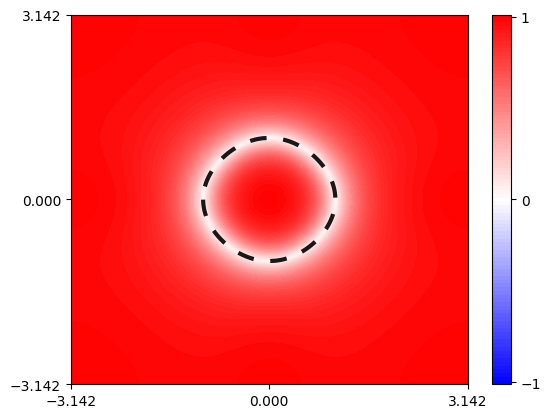

In [158]:
kx =  np.linspace(-np.pi,np.pi,100)
ky= np.linspace(-np.pi,np.pi,100)
Qx,Qy = np.meshgrid(kx,ky,indexing='ij')
plt.figure()
plt.contourf(Qx,Qy,SpinzLTST,cmap='bwr',levels=np.linspace(-1.01,1.01,100))
plt.plot(kxBIS,kyBIS,c='k',linewidth=3,alpha=0.9,linestyle=(0, (4, 4)))
plt.colorbar().set_ticks([-1, 0, 1])  # 设置 colorbar 的刻度
plt.xticks([-np.pi, 0, np.pi])
plt.yticks([-np.pi, 0, np.pi])
#plt.savefig('BIShzOnly.svg')
plt.show()

In [10]:
data = np.column_stack((Qx.ravel(), Qy.ravel(), SpinzLTST.real.ravel()))
df = pd.DataFrame(data, columns=["kx", "ky", "Spinz"])
df.to_csv("Fig_1(a)_Spinz_Ave.csv", index=False)

In [159]:

phi = np.linspace(-np.pi,np.pi,len(kxBIS))
rphi = linear_interp(phi)
kx =  rphi*np.cos(phi)
ky=   rphi*np.sin(phi)
Time=np.arange(0,50,0.1)
SpinxBIS = np.zeros((len(kxBIS)),dtype=complex)
SpinyBIS =  np.zeros((len(kxBIS)),dtype=complex)
SpinzBIS =  np.zeros((len(kxBIS)),dtype=complex)
rho0 = 1/2*(np.eye(2)+sigmaz)
SpinxQ =  np.zeros((len(kxBIS)),dtype=complex)
SpinyQ =  np.zeros((len(kxBIS)),dtype=complex)
SpinzQ =  np.zeros((len(kxBIS)),dtype=complex)
Energy = np.zeros((len(kxBIS)),dtype=complex)
for i in np.arange(len(kxBIS)):
    hz = 1j*gamma
    hx = (2*tso*np.sin(kxBIS[i]))
    hy = (2*tso*np.sin(kyBIS[i]))
    En = np.sqrt(hz**2+hx**2+hy**2)
    #Energy[i] = En
    SpinxQ[i] = hx/En+(hx.conjugate())/(En.conjugate())
    SpinyQ[i] = hy/En+(hy.conjugate())/(En.conjugate())
    SpinzQ[i] = hz/En+(hz.conjugate())/(En.conjugate())
    Energy[i] = np.sqrt((2*tso*np.sin(kxBIS[i]))**2 + (2*tso*np.sin(kyBIS[i]))**2 + (mz - 2*t0*np.cos(kxBIS[i])-2*t0*np.cos(kyBIS[i])+1j*gamma)**2)
    SpinxBIS[i],SpinyBIS[i],SpinzBIS[i] = SpinNonEmitianAveTime(mz,t0,tso,kxBIS[i],kyBIS[i],gamma,rho0,Time)

d:\anaconda\lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\anaconda\lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


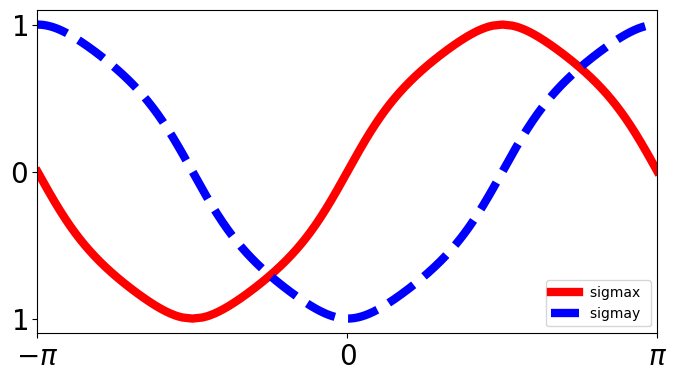

In [161]:

phi = theta1sort #np.linspace(-np.pi,np.pi,len(kxBIS))
plt.figure(figsize=(8,4.2),dpi=100)
plt.plot(phi,SpinxBIS/np.sqrt(SpinxBIS**2+SpinyBIS**2),c='r',label = 'sigmax ',linewidth=6,alpha=1)
plt.plot(phi,SpinyBIS/np.sqrt(SpinxBIS**2+SpinyBIS**2),c='b',label = 'sigmay ',linewidth=6,alpha=1,ls='--')
#plt.plot(phi,-SpinxQ/np.sqrt(SpinxQ**2+SpinyQ**2),linewidth=6,c='b',label='Spiny',ls='--')
#plt.plot(phi,SpinyQ/np.sqrt(SpinxQ**2+SpinyQ**2),linewidth=6,c='r',label='Spinx',ls='--')
plt.xticks([-np.pi,0,np.pi],[r'$-\pi$','$0$','$\pi$'],fontsize =20)
#plt.axvline(np.pi,c='gray',ls='--',linewidth = 4)
plt.yticks([-1,0,1],[r'$1$','0','$1$'],fontsize =20)
plt.ylim(-1.1,1.1)
plt.xlim(-np.pi,np.pi)
plt.legend()
#plt.savefig('ATST.svg')

In [139]:
dataBIS = np.column_stack((phi,SpinxBIS/np.sqrt(SpinxBIS**2+SpinyBIS**2), SpinyBIS/np.sqrt(SpinxBIS**2+SpinyBIS**2)))
df = pd.DataFrame(dataBIS, columns=["phi", "Spinx", "Spiny"])
df.to_csv("Fig_1(b)_Spin_Ave.csv", index=False)

In [140]:
def SpinNonEmitianTime(mz,t0,tso,kx,ky,gamma,rho0,Time): # 含时演化
    dt = Time[1]-Time[0]
    H = RammaLattice2D(mz,t0,tso,kx,ky,gamma)
    HL = H.T.conjugate()
    sigmay = np.array([[0,-1j],[1j,0]])
    sigmax = np.array([[0,1],[1,0]])
    sigmaz = np.array([[1,0],[0,-1]])
    U = np.zeros((len(Time),2,2),dtype=complex)
    UL = np.zeros((len(Time),2,2),dtype=complex)
    Spinx = np.zeros(len(Time),dtype=complex)
    Spiny = np.zeros(len(Time),dtype=complex)
    Spinz = np.zeros(len(Time),dtype=complex)
    for ti in np.arange(len(Time)):
        U[ti] = expm(-1j*H*Time[ti]) #(np.cos(E*Time[ti])*np.eye(2)-1j*np.sin(E*Time[ti])*H/E)
        UL[ti]= expm(1j*HL*Time[ti]) #(np.cos(EL*Time[ti])*np.eye(2)+1j*np.sin(EL*Time[ti])*HL/EL)
    for i in np.arange(len(Time)):
        Spinx[i]= np.trace(U[i]@rho0@UL[i]@sigmax)/np.trace(U[i]@rho0@UL[i])
        Spiny[i]= np.trace(U[i]@rho0@UL[i]@sigmay)/np.trace(U[i]@rho0@UL[i])
        Spinz[i]= np.trace(U[i]@rho0@UL[i]@sigmaz)/np.trace(U[i]@rho0@UL[i])
    return Spinx,Spiny,Spinz

In [141]:
phi = 0
rphi = linear_interp(phi)
kxpoint1 =  rphi*np.cos(phi)
kypoint1 =   rphi*np.sin(phi)
kxpoint2 =  0
kypoint2 =  np.pi/2
Time1 = np.arange(0,20,0.02)
SpinxT,SpinyT,SpinzT = SpinNonEmitianTime(mz,t0,tso,kxpoint1,kypoint1,gamma,rho0,Time1)
SpinxT1,SpinyT1,SpinzT1 = SpinNonEmitianTime(mz,t0,tso,kxpoint2,kypoint2,gamma,rho0,Time1)

d:\anaconda\lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\anaconda\lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


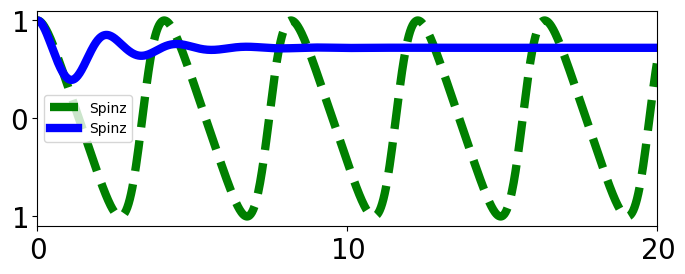

In [150]:
plt.figure(figsize=(8,2.8),dpi=100)
#plt.plot(phi,SpinxLTST/np.sqrt(SpinxLTST**2+SpinyLTST**2),c='r',label = 'sigmax ',linewidth=6,alpha=0.5)
#plt.plot(phi,SpinyLTST/np.sqrt(SpinxLTST**2+SpinyLTST**2),c='b',label = 'Spiny ',linewidth=6,alpha=0.5)
#plt.plot(q,SpinxAna/np.sqrt(SpinxAna**2+SpinyAna**2),linewidth=6,c='b',label='Spinx')
#plt.plot(q,SpinyAna/np.sqrt(SpinxAna**2+SpinyAna**2),linewidth=6,c='r',label='Spiny')
plt.plot(Time1,SpinzT,linewidth=6,c='g',label='Spinz',ls='--')
plt.plot(Time1,SpinzT1,linewidth=6,c='b',label='Spinz')
#plt.plot(Time,SpinzT1,linewidth=4,c='r',label='Spinz')
#lt.xlabel('k',fontsize=40)
plt.xticks([0,10,20,60],[r'$0$','$10$','$20$','$60$'],fontsize =20)
#plt.axvline(np.pi,c='gray',ls='--',linewidth = 4)
plt.yticks([-1,0,1],[r'$1$','0','$1$'],fontsize =20)
plt.ylim(-1.1,1.1)
plt.xlim(0,20)
plt.legend()
plt.savefig('Spin.svg')

In [151]:
dataTime = np.column_stack((Time1,SpinzT, SpinzT1))
df = pd.DataFrame(dataTime, columns=["Time", "Spinz_On_BIS", "Spinz_away_BIS"])
df.to_csv("Fig_1(a)_Spinz_Time.csv", index=False)